In [54]:
cd desktop

/Users/christopherbaker_1/Desktop


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier

## Downloading the Data

In [4]:
# Define path for JSON file where MSFT data will be saved 
PATH = "msft_data.json"

In [5]:
if os.path.exists(PATH):
    # Read from file if we've already downloaded the data
    with open(PATH) as f:
        msft_history = pd.read_json(PATH)
else:
    # Download MSFT stock prices from Yahoo finance
    msft = yf.Ticker("MSFT")
    msft_history = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_history.to_json(PATH)

In [7]:
msft_history.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,0.054893,0.062965,0.054893,0.060274,1031788800,0.0,0.0
1986-03-14 05:00:00,0.060274,0.063504,0.060274,0.062427,308160000,0.0,0.0
1986-03-17 05:00:00,0.062427,0.064042,0.062427,0.063504,133171200,0.0,0.0
1986-03-18 05:00:00,0.063504,0.064042,0.061350,0.061889,67766400,0.0,0.0
1986-03-19 05:00:00,0.061888,0.062427,0.060274,0.060812,47894400,0.0,0.0


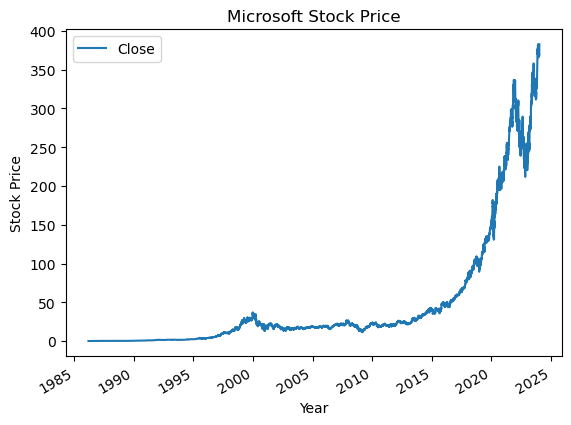

In [8]:
msft_history.plot.line(y="Close")
plt.title("Microsoft Stock Price")
plt.xlabel("Year")
plt.ylabel("Stock Price")
plt.show()

## Data Preparation

In [9]:
# Create a new DataFrame 
# [[ ]] = Creates a DataFrame 
msft_data = msft_history[["Close"]]

In [10]:
# Rename "Close" column
msft_data = msft_data.rename(columns = {"Close":"Closing_Price"})

In [11]:
msft_data.head()

,Closing_Price
1986-03-13 05:00:00,0.060274
1986-03-14 05:00:00,0.062427
1986-03-17 05:00:00,0.063504
1986-03-18 05:00:00,0.061889
1986-03-19 05:00:00,0.060812


In [12]:
# Set target
# 1 = price went up 
# 0 = price went down
price_change = msft_history["Close"].rolling(window=2).apply(lambda x: x[1] > x[0])

In [13]:
msft_data["Target"] = price_change

In [14]:
msft_data.head()

,Closing_Price,Target
1986-03-13 05:00:00,0.060274,NaN
1986-03-14 05:00:00,0.062427,1.0
1986-03-17 05:00:00,0.063504,1.0
1986-03-18 05:00:00,0.061889,0.0
1986-03-19 05:00:00,0.060812,0.0


In [15]:
# Shift msft stock price one day forward
msft_prev = msft_history.copy()
msft_prev = msft_prev.shift(1)

In [16]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 05:00:00,0.054893,0.062965,0.054893,0.060274,1.031789e+09,0.0,0.0
1986-03-17 05:00:00,0.060274,0.063504,0.060274,0.062427,3.081600e+08,0.0,0.0
1986-03-18 05:00:00,0.062427,0.064042,0.062427,0.063504,1.331712e+08,0.0,0.0
1986-03-19 05:00:00,0.063504,0.064042,0.061350,0.061889,6.776640e+07,0.0,0.0


In [17]:
predictors = ["Close", "Volume", "Open", "High", "Low"]

In [18]:
# Combine Data
combined_data = msft_data.join(msft_prev[predictors])

In [19]:
combined_data.head()

,Closing_Price,Target,Close,Volume,Open,High,Low
1986-03-13 05:00:00,0.060274,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 05:00:00,0.062427,1.0,0.060274,1.031789e+09,0.054893,0.062965,0.054893
1986-03-17 05:00:00,0.063504,1.0,0.062427,3.081600e+08,0.060274,0.063504,0.060274
1986-03-18 05:00:00,0.061889,0.0,0.063504,1.331712e+08,0.062427,0.064042,0.062427
1986-03-19 05:00:00,0.060812,0.0,0.061889,6.776640e+07,0.063504,0.064042,0.061350


In [20]:
# Skip first row
msft_data = combined_data.drop(combined_data.index[0])

In [21]:
msft_data.head()

,Closing_Price,Target,Close,Volume,Open,High,Low
1986-03-14 05:00:00,0.062427,1.0,0.060274,1.031789e+09,0.054893,0.062965,0.054893
1986-03-17 05:00:00,0.063504,1.0,0.062427,3.081600e+08,0.060274,0.063504,0.060274
1986-03-18 05:00:00,0.061889,0.0,0.063504,1.331712e+08,0.062427,0.064042,0.062427
1986-03-19 05:00:00,0.060812,0.0,0.061889,6.776640e+07,0.063504,0.064042,0.061350
1986-03-20 05:00:00,0.059198,0.0,0.060812,4.789440e+07,0.061888,0.062427,0.060274


## Create a Machine Learning Model 

In [22]:
# Create a Random Forest Model 
random_model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

In [23]:
# Create a train and test set 
train = msft_data.iloc[:-100]
test = msft_data.iloc[-100:]

In [25]:
random_model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [27]:
# Evaluate prediction errors 
preds = random_model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.7647058823529411

#### The Random Forest Classifier model is accurate 76% of the time

<Axes: >

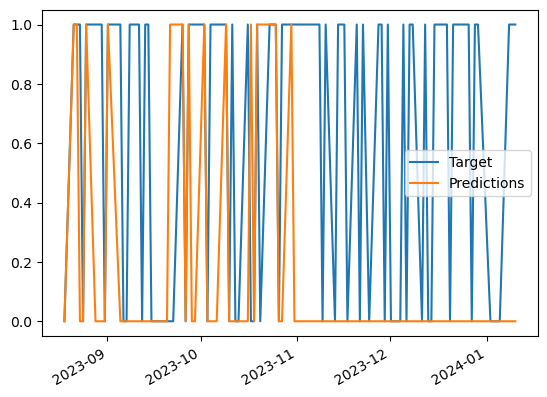

In [28]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

## Backtesting

In [42]:
def backtest(msft_data, random_model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, msft_data.shape[0], step):
        # Split into train and test sets
        train = msft_data.iloc[0:i].copy()
        test = msft_data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        random_model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = random_model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [43]:
predictions = backtest(msft_data, random_model, predictors)

In [44]:
predictions.head()

,Target,Predictions
1990-02-27 05:00:00,0.0,1.0
1990-02-28 05:00:00,1.0,1.0
1990-03-01 05:00:00,1.0,1.0
1990-03-02 05:00:00,1.0,1.0
1990-03-05 05:00:00,1.0,1.0


In [45]:
predictions["Predictions"].value_counts()

Predictions
0.0    7839
1.0     694
Name: count, dtype: int64

In [46]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5072046109510087

## Improving Accuracy

In [47]:
weekly_mean = msft_data.rolling(7).mean()
quarterly_mean = msft_data.rolling(90).mean()
annual_mean = msft_data.rolling(365).mean()
weekly_trend = msft_data.shift(1).rolling(7).mean()["Target"]

In [48]:
msft_data["weekly_mean"] = weekly_mean["Close"] / msft_data["Close"]
msft_data["quarterly_mean"] = quarterly_mean["Close"] / msft_data["Close"]
msft_data["annual_mean"] = annual_mean["Close"] / msft_data["Close"]

msft_data["annual_weekly_mean"] = msft_data["annual_mean"] / msft_data["weekly_mean"]
msft_data["annual_quarterly_mean"] = msft_data["annual_mean"] / msft_data["quarterly_mean"]
msft_data["weekly_trend"] = weekly_trend

msft_data["open_close_ratio"] = msft_data["Open"] / msft_data["Close"]
msft_data["high_close_ratio"] = msft_data["High"] / msft_data["Close"]
msft_data["low_close_ratio"] = msft_data["Low"] / msft_data["Close"]

In [49]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(msft_data.iloc[365:], random_model, full_predictors)

In [50]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5809859154929577

In [51]:
# Show how many trades made
predictions["Predictions"].value_counts()

Predictions
0.0    7884
1.0     284
Name: count, dtype: int64

<Axes: >

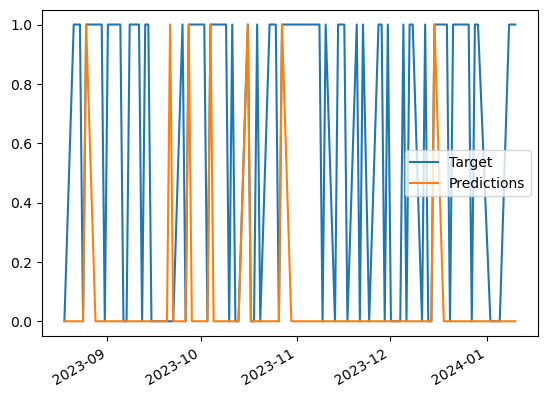

In [52]:
predictions.iloc[-100:].plot()